# QUAERO French Medical Corpus datataset

- Dataset primarily designed as a resource for Named Entity Recognition (NER) and normalization in French biomedical texts.
- The dataset was used in the CLEF eHealth evaluation labs (e.g., in 2015 and 2016)
- Language: French
- Ten types of clinical entities, defined by the following UMLS Semantic Groups, were annotated:
    - Anatomy
    - Chemical and Drugs
    - Devices
    - Disorders
    - Geographic Areas
    - Living Beings
    - Objects
    - Phenomena
    - Physiology
    - Procedures

## Data format

The data is provided in the BioC format, converted from the original BRAT format.

# Imports

In [51]:
import os, re, io, zipfile
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict
from IPython.display import display, HTML

# Loading dataset

- Selects which QUAERO subset you want to load: "emea" or "medline". Builds the HuggingFace dataset name dynamically
- Checks if an environment variable QUAERO_LOCAL_ZIP was defined. If defined, the script will load QUAERO from a local ZIP file, not from HuggingFace.

In [52]:
SUBSET = "emea"
NAME = f"quaero_{SUBSET}_source"
LOCAL_ZIP = os.environ.get("QUAERO_LOCAL_ZIP")


This enables offline BLANK loading.

In [53]:
def download_and_extract_local(zip_path, cache_dir=".cache_quaero"):
    os.makedirs(cache_dir, exist_ok=True)
    extract_dir = os.path.join(cache_dir, "extract")
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path) as zf:
            zf.extractall(extract_dir)
    root = os.path.join(extract_dir, "QUAERO_FrenchMed", "corpus")
    if not os.path.isdir(root):
        raise RuntimeError("Unexpected ZIP structure (expected: QUAERO_FrenchMed/corpus/...)")
    return root

- Tokenizes a piece of text using a simple regex that splits on whitespace.

Returns:
- a list of tokens
- a list of spans (start/end positions in the original text)

In [54]:
def tokenize_with_spans(text):
    WORD_RE = re.compile(r"\S+")
    toks, spans = [], []
    for m in WORD_RE.finditer(text):
        toks.append(m.group(0)); spans.append((m.start(), m.end()))
    return toks, spans

- Reads a .ann BRAT annotation file (manually annotated entities).
- Extracts:
    - entity type (DISO, CHEM, etc.)
    - character-level spans (offsets)

In [55]:
def parse_ann(ann_text):
    ents = []
    for line in ann_text.splitlines():
        line = line.strip()
        if not line or not line.startswith("T"):
            continue
        try:
            _tid, rest = line.split("\t", 1)
            type_and_offsets, _text = rest.split("\t", 1) if "\t" in rest else (rest, "")
            parts = type_and_offsets.split(" ")
            etype = parts[0]; offs = " ".join(parts[1:])
            spans = []
            for seg in offs.split(";"):
                seg = seg.strip()
                if not seg: 
                    continue
                s, e = seg.split()
                spans.append((int(s), int(e)))
            ents.append({"type": etype, "spans": spans})
        except Exception:
            continue
    return ents


Takes token spans + entity spans.

Applies "keep-longest" deduplication to remove nested entities.

Maps character-level entities into token-level BIO tags.

Produces something like:

In [56]:
def align_entities_to_tokens(tokens_spans, entities, labels_base=None):
    if labels_base is None:
        labels_base = ['DISO','DEVI','CHEM','GEOG','OBJC','PHEN','PHYS','LIVB','PROC','ANAT']
    n = len(tokens_spans)
    tags = ["O"] * n
    flat = []
    for ent in entities:
        if ent["type"] not in labels_base: 
            continue
        s = min(s for s, _ in ent["spans"]); e = max(e for _, e in ent["spans"])
        flat.append((s, e, ent["type"]))
    # keep-longest
    flat.sort(key=lambda x: (x[1]-x[0]), reverse=True)
    occupied = [False] * n
    for s, e, etype in flat:
        covered_idxs = [i for i, (ts, te) in enumerate(tokens_spans) if ts >= s and te <= e]
        if not covered_idxs: 
            continue
        if any(occupied[i] for i in covered_idxs):
            continue
        tags[covered_idxs[0]] = f"B-{etype}"
        for i in covered_idxs[1:]:
            tags[i] = f"I-{etype}"
        for i in covered_idxs:
            occupied[i] = True
    return tags

Loads QUAERO directly from local BRAT files. Finds the correct folder for each split: train, dev, test
- This allows usage without internet

In [57]:
def load_quaero_local(root, subset):
    base = { "train":"train", "validation":"dev", "test":"test" }
    out = {}
    for split, folder in base.items():
        subset_dir = os.path.join(root, folder, subset.upper())
        if not os.path.isdir(subset_dir):
            out[split] = Dataset.from_list([]); continue
        rows = []
        txt_files = [f for f in os.listdir(subset_dir) if f.endswith(".txt")]
        for fn in sorted(txt_files):
            stem = fn[:-4]
            with open(os.path.join(subset_dir, fn), "r", encoding="utf-8") as ft:
                text = ft.read()
            ann_path = os.path.join(subset_dir, stem + ".ann")
            ann_text = ""
            if os.path.exists(ann_path):
                with open(ann_path, "r", encoding="utf-8") as fa:
                    ann_text = fa.read()
            ents = parse_ann(ann_text)
            rows.append({
                "id": stem, "document_id": stem, "text": text,
                "text_bound_annotations": [
                    {"id": f"T{i+1}", "type": ent["type"], "offsets": ent["spans"], "text": [text[s:e] for (s,e) in ent["spans"]]}
                    for i, ent in enumerate(ents)
                ],
                "notes": []
            })
        out[split] = Dataset.from_list(rows)
    return DatasetDict(out)

- First tries to load the QUAERO dataset from the HuggingFace Hub.
- Checks if the user set QUAERO_LOCAL_ZIP=/path/to/zip
- Displays the final DatasetDict object with the three splits (train/dev/test)

In [58]:
try:
    ds = load_dataset("bigbio/quaero", name=NAME)
    print(f"Loading from HF: {NAME}")
except Exception as e:
    if LOCAL_ZIP:
        root = download_and_extract_local(LOCAL_ZIP)
        ds = load_quaero_local(root, SUBSET)
        print(f"Loading from ZIP: {LOCAL_ZIP}")
    else:
        raise RuntimeError("No internet and no QUAERO_LOCAL_ZIP definido.") from e

ds

/Users/felipebrito/miniforge3/lib/python3.12/site-packages/datasets/load.py:1491: FutureWarning: The repository for bigbio/quaero contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bigbio/quaero
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading from HF: quaero_emea_source


DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'text', 'text_bound_annotations', 'notes'],
        num_rows: 11
    })
    test: Dataset({
        features: ['id', 'document_id', 'text', 'text_bound_annotations', 'notes'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['id', 'document_id', 'text', 'text_bound_annotations', 'notes'],
        num_rows: 12
    })
})

# Helpers

Iterates through every annotated entity in a document. Each ann file entity may contain multiple spans. For every span, it creates a dictionary. This is a flat iterator of all entities, as a helper

In [59]:
def iter_entities(example):
    for ann in example.get("text_bound_annotations", []):
        etype = ann["type"]
        for i, (s, e) in enumerate(ann["offsets"]):
            yield {
                "id": ann["id"], "type": etype,
                "start": s, "end": e,
                "text": ann["text"][i] if i < len(ann["text"]) else example["text"][s:e],
            }

This gives the distribution of entity types

In [60]:
def split_stats(dataset_split):
    n_docs = len(dataset_split)
    n_chars = sum(len(ex["text"]) for ex in dataset_split)
    ent_counter = Counter()
    for ex in dataset_split:
        ent_counter.update([ent["type"] for ent in iter_entities(ex)])
    df_types = pd.DataFrame([{"type": t, "count": c} for t, c in ent_counter.most_common()])
    return n_docs, n_chars, df_types

Detects whether any two entities overlap in the text.

In [61]:
def has_overlap(ents):
    ents = sorted(ents, key=lambda x: (x[0], x[1]))
    for i in range(1, len(ents)):
        if ents[i][0] < ents[i-1][1]:
            return True
    return False

Counts how many documents contain nesting.

In [62]:
def nesting_rate(dataset_split):
    n_with = 0
    for ex in dataset_split:
        spans = [(ent["start"], ent["end"]) for ent in iter_entities(ex)]
        if has_overlap(spans):
            n_with += 1
    return n_with, len(dataset_split), n_with / max(1, len(dataset_split))


Creates a mapping:
annotation ID → list of UMLS CUIs. This enables NER+linking tasks

In [63]:
def build_cui_index(example):
    ref_to_cuis = defaultdict(list)
    for n in example.get("notes", []):
        if n.get("type") == "AnnotatorNotes":
            ref_to_cuis[n["ref_id"]].extend(n.get("text","").split())
    return ref_to_cuis

Counts the most frequent UMLS CUIs present in the split.

In [64]:
def top_cuis(dataset_split, k=20):
    c = Counter()
    for ex in dataset_split:
        idx = build_cui_index(ex)
        for ann in ex.get("text_bound_annotations", []):
            for cui in idx.get(ann["id"], []):
                c[cui] += 1
    return pd.DataFrame([{"cui": cui, "count": cnt} for cui, cnt in c.most_common(k)])

# Stats per split

In [65]:
for split in ds.keys():
    n_docs, n_chars, df_types = split_stats(ds[split])
    print(f"\n=== {split.upper()} ===")
    print(f"docs: {n_docs:,} | chars: {n_chars:,}")
    if not df_types.empty:
        display(df_types)



=== TRAIN ===
docs: 11 | chars: 85,645


,type,count
0,DISO,762
1,CHEM,727
2,PROC,435
3,LIVB,273
4,ANAT,247
5,PHYS,119
6,OBJC,71
7,DEVI,48
8,GEOG,22
9,PHEN,19



=== TEST ===
docs: 15 | chars: 67,366


,type,count
0,CHEM,885
1,DISO,350
2,LIVB,275
3,PROC,269
4,ANAT,182
5,DEVI,100
6,PHYS,85
7,OBJC,53
8,PHEN,33
9,GEOG,14



=== VALIDATION ===
docs: 12 | chars: 74,800


,type,count
0,CHEM,870
1,DISO,469
2,LIVB,277
3,PROC,252
4,ANAT,155
5,PHYS,141
6,OBJC,50
7,GEOG,29
8,DEVI,22
9,PHEN,10


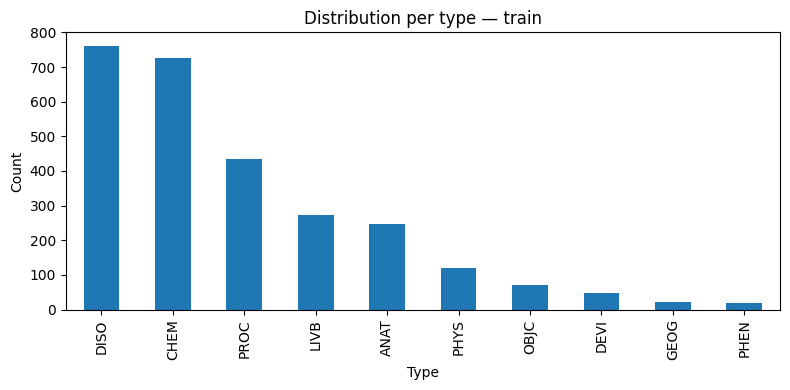

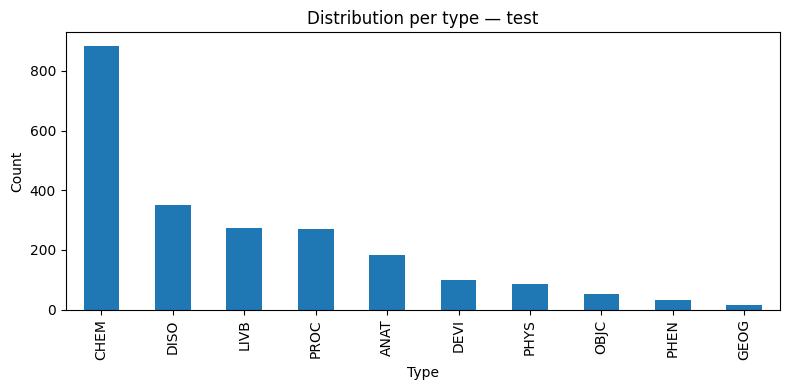

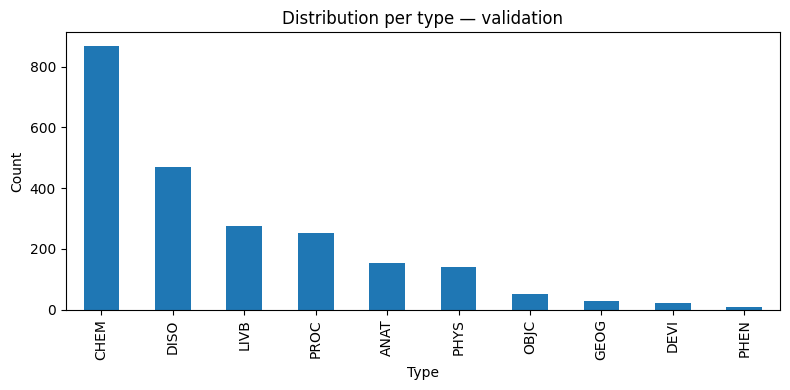

In [66]:
import matplotlib.pyplot as plt

def plot_distribution(df_types, title):
    ax = df_types.plot(kind="bar", x="type", y="count", legend=False, figsize=(8,4))
    ax.set_title(title); ax.set_xlabel("Type"); ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

for split in ds.keys():
    _, _, df_types = split_stats(ds[split])
    plot_distribution(df_types, f"Distribution per type — {split}")


# Visualizing the entities

This function visually highlights all entities inside a document by producing HTML with colored spans.

In [72]:
def highlight_html(ex, max_chars=1200):
    palette = {
        "ANAT":"#4e79a7","DISO":"#e15759","CHEM":"#b07aa1","PROC":"#f28e2b","PHYS":"#59a14f",
        "LIVB":"#76b7b2","DEVI":"#af7aa1","GEOG":"#9c755f","OBJC":"#bab0ab","PHEN":"#edc948",
    }
    text = ex["text"][:max_chars]
    ents = sorted(
        [(ent["start"], ent["end"], ent["type"]) for ent in iter_entities(ex) if ent["end"] <= len(text)],
        key=lambda x: x[0], reverse=True
    )
    html = text
    for s, e, t in ents:
        color = palette.get(t, "#000")
        html = html[:s] + f'<span style="background:{color};color:#fff;padding:1px 2px;border-radius:2px">' + html[s:e] + "</span>" + html[e:]
    return HTML(f"<pre style='white-space:pre-wrap'>{html}</pre>")

for split in ds.keys():
    n_with, den, rate = nesting_rate(ds[split])
    print(f"{split}: {n_with}/{den} docs com sobreposição ({rate:.1%})")

if len(ds["train"]) > 0:
    display(highlight_html(ds["train"][0], max_chars=1200))


train: 11/11 docs com sobreposição (100.0%)
test: 15/15 docs com sobreposição (100.0%)
validation: 12/12 docs com sobreposição (100.0%)


This block measures how often certain medication-related patterns appear in the QUAERO text, using regular expressions.

In [74]:
UNITS = r"(mg|µg|mcg|g|kg|mL|ml|L|UI|u[iI]|%)"
FREQ  = r"((\\d+\\s*[x×]\\s*/\\s*j)|(\\d+\\s*/\\s*j)|(\\d+\\s*fois\\s*par\\s*jour)|(?:q\\s*\\d+\\s*h)|(?:toutes?\\s*les?\\s*\\d+\\s*h))"
DUR   = r"(pendant\\s*\\d+\\s*(j|jours|semaines?)|pour\\s*\\d+\\s*(j|jours))"
ROUTE = r"\\b(IV|IM|SC|PO|orale?|intraveineuse|intramusculaire|sous\\-cutan[ée]e|inhal[ée]e|topique)\\b"
FORM  = r"\\b(cp|gél|gélule|comprim[ée]s?|solution|pommade|sirop|sachet|suspension)\\b"

def coverage_counts(dataset_split, max_docs=2000):
    n = min(len(dataset_split), max_docs)
    counts = {"UNITS":0, "FREQ":0, "DUR":0, "ROUTE":0, "FORM":0}
    for i in range(n):
        txt = dataset_split[i]["text"]
        counts["UNITS"] += len(re.findall(UNITS, txt, flags=re.IGNORECASE))
        counts["FREQ"]  += len(re.findall(FREQ,  txt, flags=re.IGNORECASE))
        counts["DUR"]   += len(re.findall(DUR,   txt, flags=re.IGNORECASE))
        counts["ROUTE"] += len(re.findall(ROUTE, txt, flags=re.IGNORECASE))
        counts["FORM"]  += len(re.findall(FORM,  txt, flags=re.IGNORECASE))
    return n, counts

for split in ds:
    n, c = coverage_counts(ds[split])
    print(f"{split}: {n} docs varridos")
    print(c)


train: 11 docs varridos
{'UNITS': 4010, 'FREQ': 0, 'DUR': 0, 'ROUTE': 0, 'FORM': 0}
test: 15 docs varridos
{'UNITS': 3038, 'FREQ': 0, 'DUR': 0, 'ROUTE': 0, 'FORM': 0}
validation: 12 docs varridos
{'UNITS': 3868, 'FREQ': 0, 'DUR': 0, 'ROUTE': 0, 'FORM': 0}


This entire block converts raw QUAERO documents (character-level spans) into a HuggingFace DatasetDict formatted for token-classification (BIO tags).

In [75]:
def to_bio_dataset(ds_source):
    out = {}
    for split in ds_source.keys():
        rows = []
        for ex in ds_source[split]:
            toks, spans = tokenize_with_spans(ex["text"])
            ents = [(ent["start"], ent["end"], ent["type"]) for ent in iter_entities(ex)]
            ents_norm = [{"type": t, "spans":[(s,e)]} for (s,e,t) in ents]
            tags = align_entities_to_tokens(spans, ents_norm)
            rows.append({"id": ex["id"], "document_id": ex["document_id"], "tokens": toks, "ner_tags": tags})
        out[split] = Dataset.from_list(rows)
    return DatasetDict(out)

ds_tok = to_bio_dataset(ds)
print(ds_tok)
if len(ds_tok["train"])>0:
    print(ds_tok["train"][0]["tokens"][:25])
    print(ds_tok["train"][0]["ner_tags"][:25])

EXPORT = False
EXPORT_DIR = f"exports/quaero_{SUBSET}_tok"
if EXPORT:
    os.makedirs(EXPORT_DIR, exist_ok=True)
    for split, dset in ds_tok.items():
        dset.to_parquet(f"{EXPORT_DIR}/{split}.parquet")
    print("Export salvo em:", EXPORT_DIR)


DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'tokens', 'ner_tags'],
        num_rows: 11
    })
    test: Dataset({
        features: ['id', 'document_id', 'tokens', 'ner_tags'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['id', 'document_id', 'tokens', 'ner_tags'],
        num_rows: 12
    })
})
['EMEA', '/', 'H', '/', 'C', '/', '551', 'PRIALT', 'Qu', '’', 'est', 'ce', 'que', 'Prialt', '?', 'Prialt', 'est', 'une', 'solution', 'pour', 'perfusion', 'contenant', 'le', 'principe', 'actif']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CHEM', 'O', 'O', 'O', 'O', 'O', 'B-CHEM', 'O', 'B-CHEM', 'O', 'O', 'B-CHEM', 'O', 'B-PROC', 'O', 'O', 'B-CHEM', 'I-CHEM']


In [77]:
import random

def ocr_noise(text, prob=0.01):
    subs = {"é":"e","è":"e","ê":"e","ë":"e","à":"a","â":"a","ä":"a",
            "î":"i","ï":"i","ô":"o","ö":"o","û":"u","ü":"u","’":"'", "–":"-","—":"-"}
    out = []
    for ch in text:
        if random.random() < prob:
            if ch in subs: out.append(subs[ch])
            elif ch.isalpha(): out.append(ch.lower())
            else: out.append(ch)
        else:
            out.append(ch)
    return "".join(out)

def coverage_with_noise(dataset_split, noise_prob=0.02, k=50):
    n = min(len(dataset_split), k)
    counts = {"UNITS":0, "FREQ":0, "DUR":0, "ROUTE":0, "FORM":0}
    for i in range(n):
        txt = ocr_noise(dataset_split[i]["text"], prob=noise_prob)
        counts["UNITS"] += len(re.findall(UNITS, txt, flags=re.IGNORECASE))
        counts["FREQ"]  += len(re.findall(FREQ,  txt, flags=re.IGNORECASE))
        counts["DUR"]   += len(re.findall(DUR,   txt, flags=re.IGNORECASE))
        counts["ROUTE"] += len(re.findall(ROUTE, txt, flags=re.IGNORECASE))
        counts["FORM"]  += len(re.findall(FORM,  txt, flags=re.IGNORECASE))
    return n, counts

n, c = coverage_with_noise(ds["train"], noise_prob=0.02, k=50)
print("With noise in OCR simulated (p=0.02) in 50 docs:", c)


With noise in OCR simulated (p=0.02) in 50 docs: {'UNITS': 4010, 'FREQ': 0, 'DUR': 0, 'ROUTE': 0, 'FORM': 0}
